# Analysis of experiments
Goals are to
- [DONE] visualize the evolution of the energy consumption of the server and the clients during the training
- [DONE] visualize the evolution of the local and global loss/accuracy
- [DONE] Compute the local/total energy consumption of each experiments
- Compare experiments
    - complete experiment_summary with 
        - final accuacry (centralized, distributed max, dist avg)
        - [DONE] total energy
        - energy per client
        - number of rounds to reach accuracy
        - training time
- Compute the energy consumption of each round for each hosts/clients
    - study the impact of training several clients on one host
- is the energy consumed by each round stable? How does the number of epoch impacts it?

Remarks:
- Power is in milliwatts
- outputcifar10/fedavg
    - issue with host7: no energy data for most of the experiments

This notebook requires running the process_energy.py script beforehand.

## Imports and paths

In [3]:
import matplotlib.pyplot as plt
import seaborn.objects as so
from seaborn import axes_style
theme_dict = {**axes_style("whitegrid"), "grid.linestyle": ":"}
so.Plot.config.theme.update(theme_dict)
import os
import pandas as pd
from pathlib import Path
import glob
import time
from datetime import datetime
import sys
sys.path.append('/home/mjay/FL-G5K-Test/src/utils')

from process_results import EnergyResult, read_summaryfile, config_drop, match_folder_csv, select_model
from process_energy import compute_exp_energy_per_host, compute_host_energy, compute_exp_energy

## Visualisation of raw csvs

In [ ]:
from process_results import match_folder_csv, select_model
result_plot = {#"loss": ["results","server_round","loss","losses_centralized","losses_distributed"],}
                "accuracy": ["results","server_round","accuracy","acc_centralized","acc_distributed"]}
outputs_path = [
    "/home/mjay/energyfl/outputcifar10/fedyogi/labelskew",
    "/home/mjay/energyfl/outputcifar10/fedavg/labelskew",
    "/home/mjay/energyfl/outputcifar10/fedadam/labelskew",
    "/home/mjay/energyfl/outputcifar10/fedadagrad/labelskew"
]
path_to_output = "/home/tunguyen/energyfl/outputcifar10/fedyogi/labelskew"
summary_path = os.path.join(path_to_output,"experiment_summary.csv")
summaryfile = read_summaryfile(summary_path)
summaryfile = match_folder_csv(summaryfile, path_to_output)
summaryfile = select_model(summaryfile, "ResNet18") # select only ResNet
results_dir_ls = summaryfile["result_folder"].tolist()
summaryfile_dict = summaryfile.to_dict(orient="records")
for (result_dir,config) in zip(results_dir_ls,summaryfile_dict):
    result = EnergyResult(result_dir,summaryfile)
    #result.make_energy_plot("energy",'timestamp',"tot avg power (mW)")
    config = config_drop(config)
    result.make_server_plot(config,centralized=True, **result_plot)
    result.make_energy_plot("energy",'timestamp',"RAM%")
    result.make_energy_plot("energy",'timestamp',"GPU inst power (mW)")
    result.make_energy_plot("energy",'timestamp',"CPU%")
    result.make_energy_plot("energy",'timestamp',"CPU inst power (mW)")
    result.make_energy_plot("energy",'timestamp',"tot inst power (mW)")

# Experiment energy

In [162]:
outputs_path = [
    "/home/mjay/energyfl/outputcifar10/fedyogi/labelskew",
    "/home/mjay/energyfl/outputcifar10/fedavg/labelskew",
    "/home/mjay/energyfl/outputcifar10/fedadam/labelskew",
    "/home/mjay/energyfl/outputcifar10/fedadagrad/labelskew"
]
results = pd.DataFrame()
for path in outputs_path:
    perf_summary = pd.read_csv(os.path.join(path,"perf_summary.csv"))
    exp_summary = pd.read_csv(os.path.join(path,"experiment_summary.csv"))
    exp_summary["exp_id"] = exp_summary["result_folder"].apply(lambda x: x.split("/")[-1])
    perf_summary["exp_id"] = perf_summary["result_folder"].apply(lambda x: x.split("/")[-1])
    summary = exp_summary.merge(perf_summary, on="exp_id")
    results = pd.concat([results, summary], ignore_index=True)

In [164]:
results.columns

Index(['result_folder_x', 'energy_file', 'server', 'sleep_duration',
       'neuralnet', 'strategy', 'optimizer', 'estats-11', 'estats-12',
       'estats-2', 'estats-3', 'estats-4', 'estats-5', 'estats-6', 'estats-7',
       'estats-8', 'estats-9', 'timestamps.start_experiment_before_sleep',
       'timestamps.start_experiment', 'timestamps.end_experiment',
       'timestamps.end_experiment_after_sleep', 'params.num_rounds',
       'params.num_clients_per_round_fit', 'params.num_clients_per_round_eval',
       'params.min_available_clients', 'params.fraction_fit',
       'params.fraction_evaluate', 'params.wait_round', 'params.lr',
       'params.num_groups', 'data.data_name', 'data.batch_size',
       'data.validation_split', 'data.num_clients', 'data.alpha',
       'data.partition', 'client.lr', 'client.local_epochs',
       'client.decay_rate', 'client.decay_steps', 'comm.host', 'comm.port',
       'exp_id', 'result_folder_y', 'clients_J', 'clients_kWh', 'server_J',
       'server_

In [15]:
results["total_kWh"] = results["clients_kWh"] + results["server_kWh"]

In [133]:
parameters = [
    "strategy", 
    'params.wait_round', 
    'data.batch_size', 
    'client.lr',
    'client.local_epochs', 
    ]
results.groupby(parameters)[["total_kWh"]].count().style.background_gradient(cmap='viridis', low=0.2, high=0.2, axis=0)

In [16]:

perf_metrics = [
    "total_kWh",
    "max_centralized_accuracy", 
    "max_distributed_accuracy", 
    "round_number"
    ]
results.groupby(parameters)[perf_metrics].mean().style.background_gradient(cmap='viridis', low=0.2, high=0.2, axis=0)

In [69]:
results[["data.batch_size"]].describe()

data.batch_size
count        26.000000
mean         29.461538
std          29.597609
min          20.000000
25%          20.000000
50%          20.000000
75%          20.000000
max         128.000000

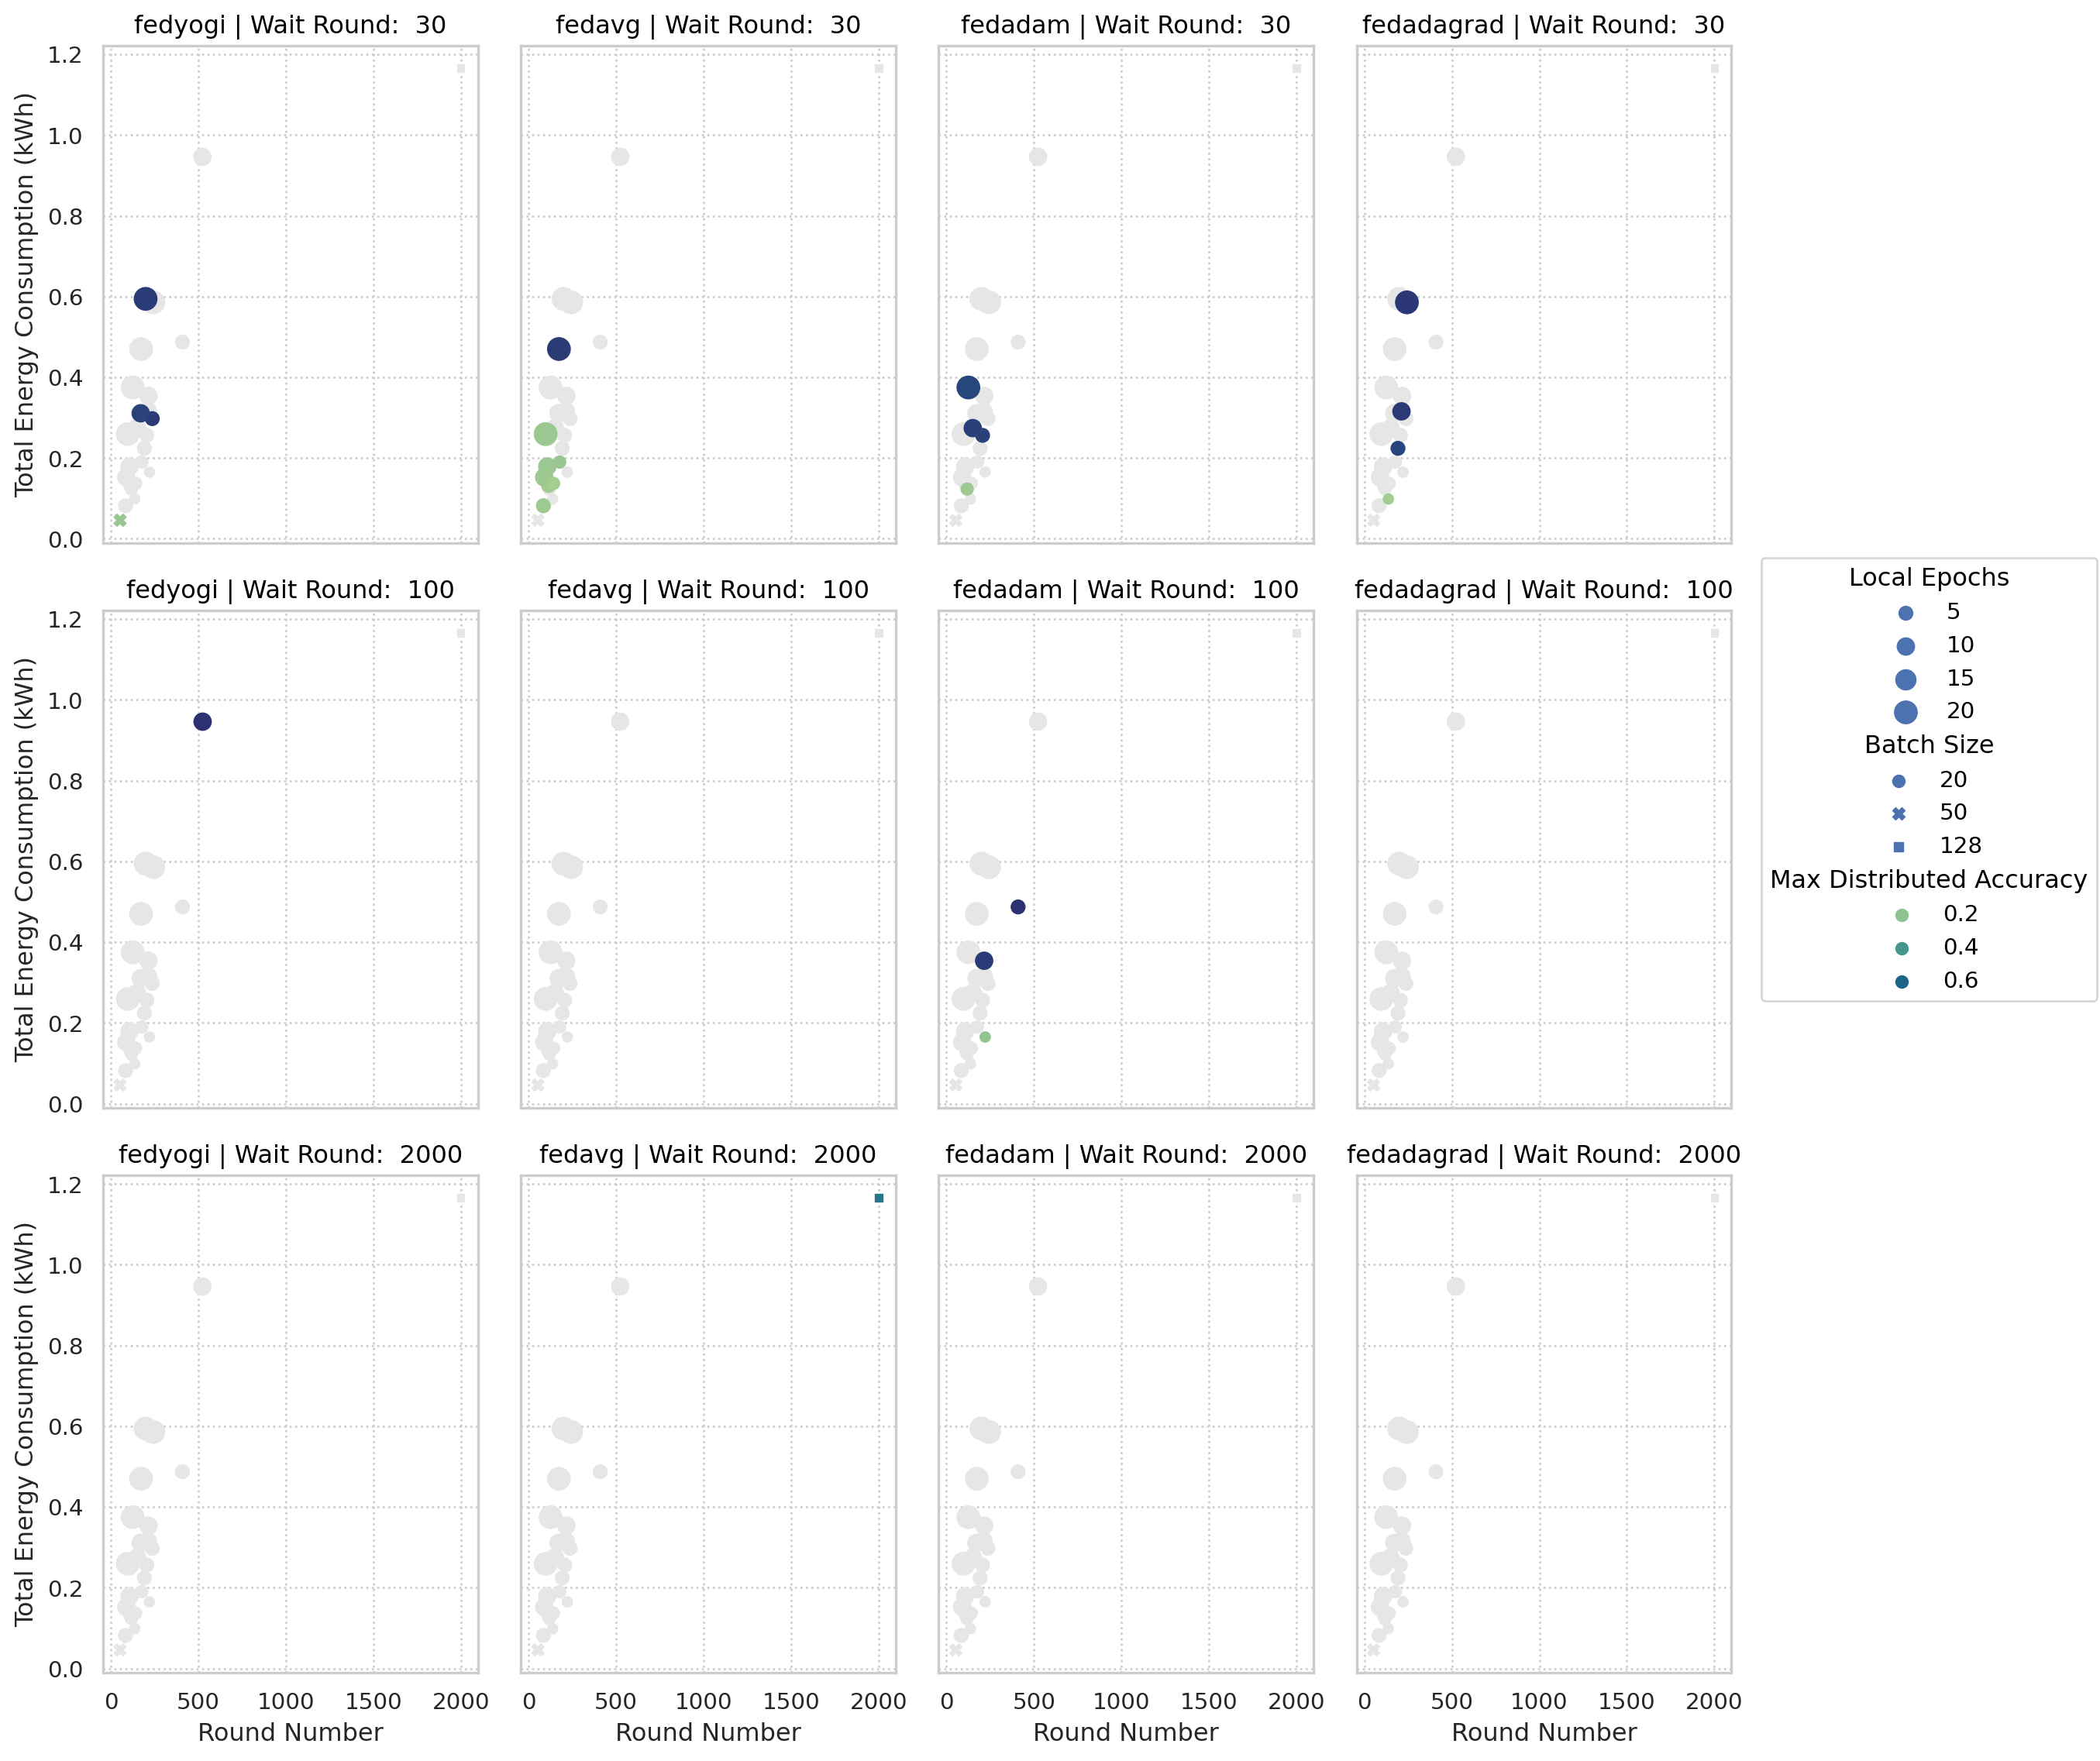

In [136]:
plot_data = results #[results["max_centralized_accuracy"]>0.1]
f = plt.Figure(figsize=(12, 12))
(
    so.Plot(
        plot_data, x="round_number", y="total_kWh",
        pointsize="client.local_epochs", color="max_distributed_accuracy",
        marker="data.batch_size",
    )
    .facet(
        col="strategy",
        row="params.wait_round")
    .add(so.Dot(color=".9"), col=None, color=None, row=None)
    .add(so.Dot())
    .scale(
        pointsize=(5, 11), 
        color="crest")
    .label(
        x="Round Number", 
        y="Total Energy Consumption (kWh)", 
        pointsize="Local Epochs", 
        color="Max Distributed Accuracy", 
        row="Wait Round: ", 
        marker="Batch Size",
        bbox_to_anchor=(1.05, 1),
        #col="Strategy:"
    )
    .layout(engine="tight")
    .on(f)
)

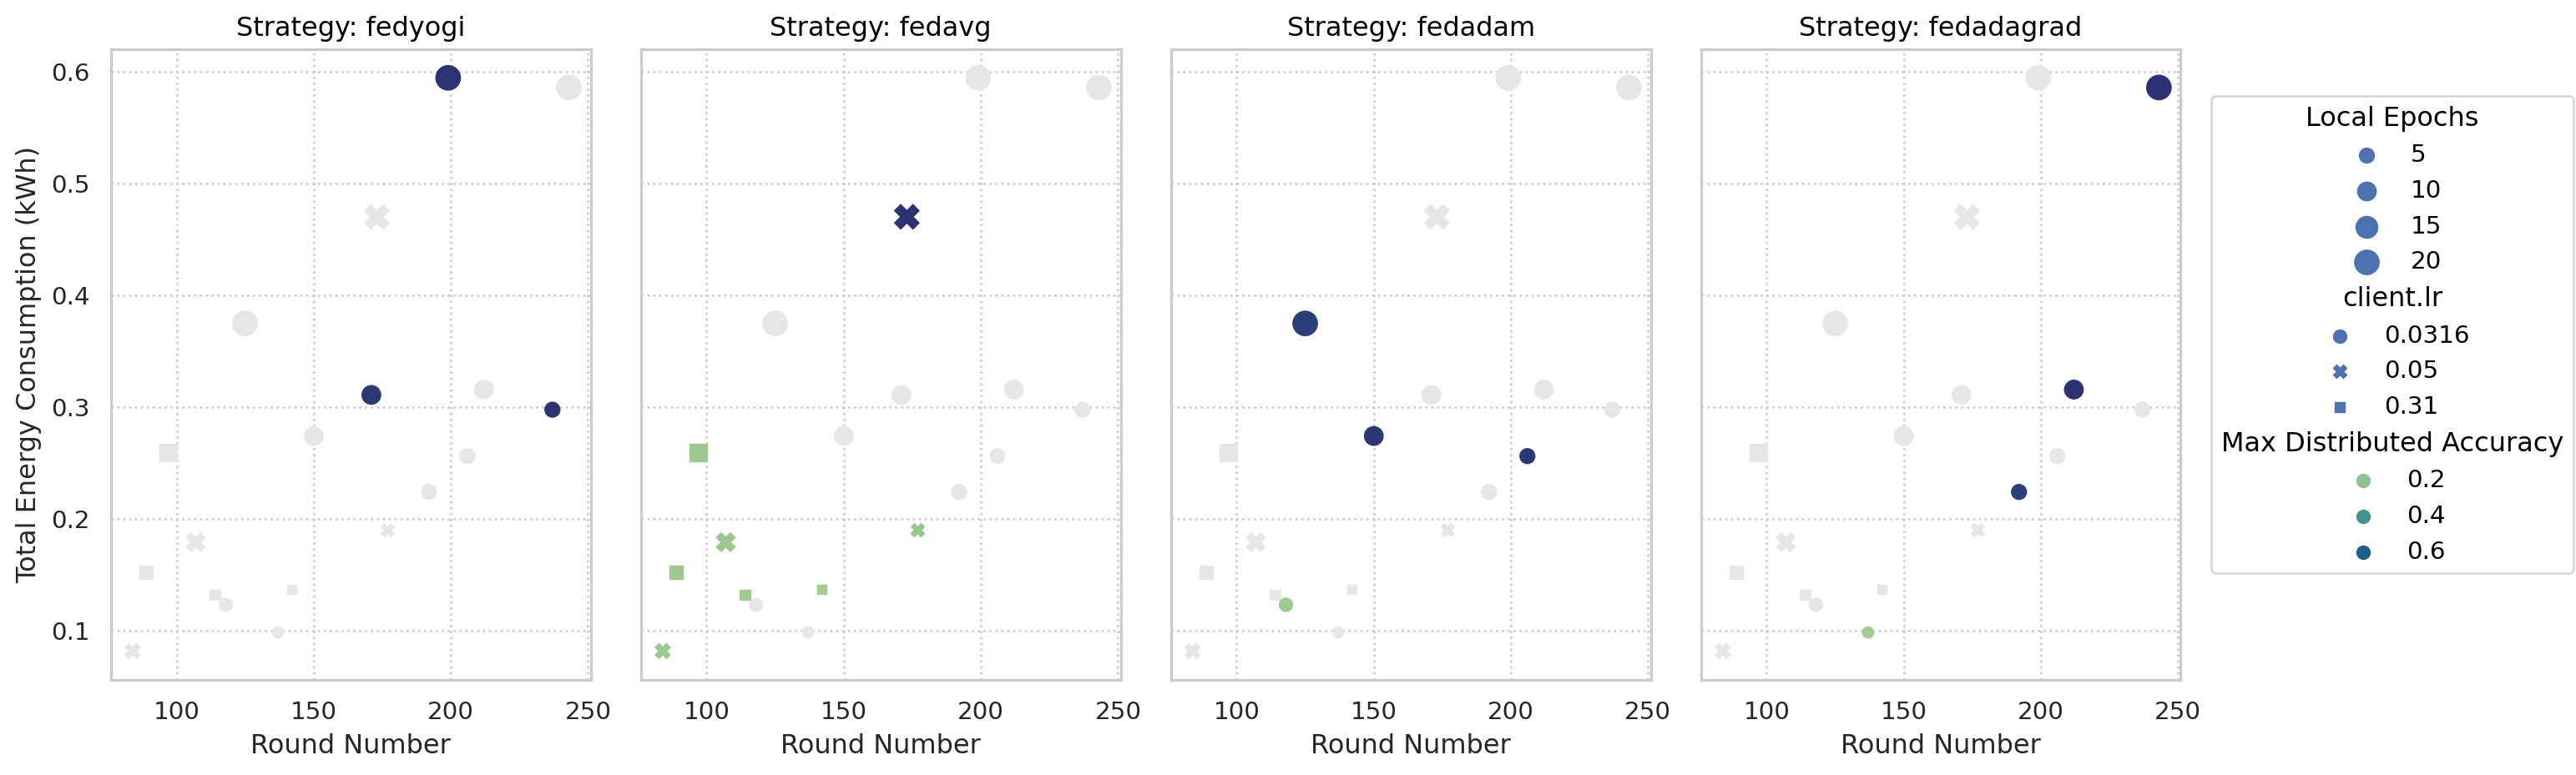

In [134]:
plot_data = results[(results["data.batch_size"] == 20)&(results["params.wait_round"] == 30)]  
sf1 = plt.Figure(figsize=(14, 5))
(
    so.Plot(
        plot_data, x="round_number", y="total_kWh",
        pointsize="client.local_epochs", color="max_distributed_accuracy",
        marker="client.lr"
    )
    .facet(col="strategy",)
    .add(so.Dot(color=".9"), col=None, color=None)
    .add(so.Dot())
    .scale(pointsize=(5, 11), color="crest")
    .label(x="Round Number", y="Total Energy Consumption (kWh)",col="Strategy:", pointsize="Local Epochs", color="Max Distributed Accuracy")
    .layout(engine="tight")
    .on(sf1)
)
# sf1.legend(bbox_to_anchor=(1.05, 1))

Those last graphs show the relationship between the number of local epochs, the strategy, the number of rounds and the energy consumption. The main observation is that the algorithm needs a minimum number of local epochs to learn. For most strategy, 5 local epochs leads to no learning, and a max accuracy below 0.2. And for fedavg, the algorithm requires at least 20 local epochs to reach an accuracy higher than 0.6. 
Other observations:
- reaching an accuracy higher than 0.6 requires in average more energy and more rounds, which can be expected. It seems that there is only two scenarios: it doesn't learn at all and is stoped very early by wait_round, or it reaches the target accuracy 0.7. The second option systematically consumes more energy, but not significantly more. 
- The higher the number of local epochs, the higher the energy consumption. Even accross stragetes, the number of local epochs seems to be the most impactfull parameters regarding the total energy consumption. One exception is for fedavg and a lr of 0.05. 
- The number of rounds is not proportional to the energy consumption. Maybe we could have a look at the total number of local epochs (local epochs times the number of rounds)?

Il n'y a pas deux expériences avec les mêmes paramètres donc on ne peux pas savoir l'impact de la variabilité de l'entraînement : est ce que les différences entre les résultats sont dus aux paramètres ou aux aléa de l'entraînement ? Il faudrait faire tourner les experiences au moins 5 fois, quitte à mettre un early stopping sur le nombre de rounds et pas seulement avec le wait round. 

## Studying energy per rounds

In [4]:
path_to_output = "/home/tunguyen/energyfl/outputcifar10/fedadam/labelskew"
summary_path = os.path.join(path_to_output,"experiment_summary.csv")
summaryfile = read_summaryfile(summary_path)
summaryfile = match_folder_csv(summaryfile, path_to_output)
summaryfile = select_model(summaryfile, "ResNet18") # select only ResNet
results_dir_ls = summaryfile["result_folder"].tolist()
summaryfile_dict = summaryfile.to_dict(orient="records")
for (result_dir,config) in zip(results_dir_ls,summaryfile_dict):
    result = EnergyResult(result_dir,summaryfile)
    #result.make_energy_plot("energy",'timestamp',"tot avg power (mW)")
    config = config_drop(config)
    # result.make_server_plot(config,centralized=True, **result_plot)
    break

In [5]:
hostmetadata = result._get_selectedclient_in_host()
len(hostmetadata)

10

In [6]:
client_results = result.clients_results()
training_results = pd.DataFrame()
clients = []
hostmetadata = result._get_selectedclient_in_host()
for hid in range(len(hostmetadata)):

    hostinfo = result._read_client_host(hid)
    hostname = hostinfo.hostname
    client_data = hostinfo.clients
    for client in client_data:
        res = client_data[client]
            
        client_res = res.fittimes.merge(res.fitresults, left_on="Server Round", right_on="server_round")
        drop_col = ["Local Epochs", "Server Round", "LR", "time"]
        client_res = client_res.drop(columns=drop_col)
        client_res["round_role"] = "train"
        cid = client_res["Client ID"].unique()[0]
        res.results.rename(columns={col:"eval_"+col for col in res.results.columns if col!="server_round"}, inplace=True)
        res.results["Client ID"] = cid
        res.results["round_role"] = "eval"
        client_res = pd.concat([client_res, res.results])
        client_res["hostname"] = hostname
        training_results = pd.concat([training_results, client_res])

In [7]:

# pour chaque host calcule l'energie pour chaque round
# for round_id in range(len(client_res)):
#     start_time, end_time = client_res.at[round_id,"Start Time"], client_res.at[round_id,"End Time"]
#     energy_df = host_energy.energy[(host_energy.energy["timestamp"]>=start_time) & (host_energy.energy["timestamp"]<=end_time)]
#     energy_kWh, energy_J = compute_energy(energy_df)
#     client_res.at[round_id,"energy_kWh"] = energy_kWh
#     client_res.at[round_id,"energy_J"] = energy_J

NameError: name 'host_energy' is not defined

In [8]:
training_results.groupby(["server_round"]).count()["train_loss"].unique()

array([ 0, 10])

In [9]:
training_results.groupby(["server_round"]).count()["eval_loss"].unique()

array([30])

In [22]:
# def style_negative(v, props=''):
#     return props if v < 0 else None
# s2 = df2.style.map(style_negative, props='color:red;')\
#               .map(lambda v: 'opacity: 20%;' if (v < 0.3) and (v > -0.3) else None)
# s2

def style_round_role(role):
    return 'background-color:lightgreen;' if role == "train" else 'background-color:red;'

In [24]:
training_results[(training_results["server_round"]<3)&(training_results["server_round"]>1)].groupby(["server_round", "hostname", "Client ID"]).first()[["round_role"]].style.map(style_round_role)

In [27]:
training_results[(training_results["hostname"]=="client_host_0")&training_results["server_round"]<4].groupby(["hostname", "server_round", "Client ID"]).first()[["round_role"]].style.map(style_round_role)

In [48]:
client_data['client_98'].fittimes

Client ID  Server Round          Start Time            End Time      LR  \
0          98            14 2024-02-28 11:03:08 2024-02-28 11:03:17  0.0316   
1          98            17 2024-02-28 11:05:08 2024-02-28 11:05:21  0.0316   
2          98            24 2024-02-28 11:10:07 2024-02-28 11:10:22  0.0316   
3          98            37 2024-02-28 11:19:05 2024-02-28 11:19:13  0.0316   
4          98            50 2024-02-28 11:28:00 2024-02-28 11:28:11  0.0316   
5          98            51 2024-02-28 11:28:39 2024-02-28 11:28:51  0.0316   
6          98            54 2024-02-28 11:30:43 2024-02-28 11:30:51  0.0316   
7          98            62 2024-02-28 11:36:02 2024-02-28 11:36:10  0.0316   
8          98            65 2024-02-28 11:38:04 2024-02-28 11:38:20  0.0316   
9          98            73 2024-02-28 11:43:47 2024-02-28 11:44:01  0.0316   
10         98            75 2024-02-28 11:45:11 2024-02-28 11:45:27  0.0316   
11         98            85 2024-02-28 11:52:17 2024-02-28 11:52:28  0.0316   
12         98           116 2024-02-28 12:13:26 2024-02-28 12:13:37  0.0316   
13         98           124 2024-02-28 12:18:51 2024-02-28 12:19:17  0.0316   
14         98           140 2024-02-28 12:29:50 2024-02-28 12:30:03  0.0316   
15         98           151 2024-02-28 12:37:10 2024-02-28 12:37:17  0.0316   
16         98           160 2024-02-28 12:43:18 2024-02-28 12:43:26  0.0316   
17         98           162 2024-02-28 12:44:39 2024-02-28 12:44:56  0.0316   
18         98           163 2024-02-28 12:45:22 2024-02-28 12:45:32  0.0316   
19         98           169 2024-02-28 12:49:38 2024-02-28 12:49:50  0.0316   
20         98           183 2024-02-28 12:59:00 2024-02-28 12:59:10  0.0316   
21         98           187 2024-02-28 13:01:43 2024-02-28 13:01:50  0.0316   
22         98           213 2024-02-28 13:19:33 2024-02-28 13:19:41  0.0316   
23         98           232 2024-02-28 13:32:40 2024-02-28 13:32:53  0.0316   
24         98           241 2024-02-28 13:38:41 2024-02-28 13:38:54  0.0316   
25         98           265 2024-02-28 13:54:50 2024-02-28 13:55:03  0.0316   
26         98           286 2024-02-28 14:08:53 2024-02-28 14:09:06  0.0316   
27         98           291 2024-02-28 14:12:18 2024-02-28 14:12:29  0.0316   
28         98           293 2024-02-28 14:13:36 2024-02-28 14:13:43  0.0316   
29         98           322 2024-02-28 14:33:24 2024-02-28 14:33:37  0.0316   
30         98           328 2024-02-28 14:37:30 2024-02-28 14:37:38  0.0316   
31         98           346 2024-02-28 14:49:43 2024-02-28 14:49:54  0.0316   
32         98           347 2024-02-28 14:50:23 2024-02-28 14:50:30  0.0316   
33         98           348 2024-02-28 14:51:03 2024-02-28 14:51:16  0.0316   
34         98           354 2024-02-28 14:55:10 2024-02-28 14:55:22  0.0316   
35         98           356 2024-02-28 14:56:27 2024-02-28 14:56:35  0.0316   
36         98           358 2024-02-28 14:57:42 2024-02-28 14:57:49  0.0316   
37         98           363 2024-02-28 15:01:07 2024-02-28 15:01:15  0.0316   
38         98           381 2024-02-28 15:13:19 2024-02-28 15:13:32  0.0316   
39         98           400 2024-02-28 15:26:16 2024-02-28 15:26:27  0.0316   

    Local Epochs  fittime  
0              5      9.0  
1              5     13.0  
2              5     15.0  
3              5      8.0  
4              5     11.0  
5              5     12.0  
6              5      8.0  
7              5      8.0  
8              5     16.0  
9              5     14.0  
10             5     16.0  
11             5     11.0  
12             5     11.0  
13             5     26.0  
14             5     13.0  
15             5      7.0  
16             5      8.0  
17             5     17.0  
18             5     10.0  
19             5     12.0  
20             5     10.0  
21             5      7.0  
22             5      8.0  
23             5     13.0  
24             5     13.0  
25             5     13.0  
26      

In [23]:
training_results[training_results["round_role"]=="train"].groupby("server_round").count()["train_acc"].unique()

array([10])

In [26]:
training_results[training_results["round_role"]=="eval"].groupby("server_round").count()["eval_loss"].unique()

array([30])

In [11]:
client_res[client_res["server_round"]==61]

Client ID          Start Time            End Time  fittime  server_round  \
3           4 2024-02-28 11:35:21 2024-02-28 11:35:33     12.0            61   
16          4                 NaT                 NaT      NaN            61   

    train_loss  train_acc  val_loss   val_acc      lr  local_epochs  \
3     0.514912   0.833659  0.492342  0.807692  0.0316           5.0   
16         NaN        NaN       NaN       NaN     NaN           NaN   

   round_role           eval_time  eval_loss  eval_accuracy  
3       train                 NaT        NaN            NaN  
16       eval 2024-02-28 11:35:51   1.256561       0.538462

In [216]:
counts = client_res.groupby(["server_round"]).count()["Client ID"]
counts[counts>1]

server_round
61     2
91     2
100    2
146    2
180    2
193    2
320    2
322    2
345    2
373    2
375    2
Name: Client ID, dtype: int64

In [ ]:
result = EnergyResult(result_folder, 6, "2024-01-20","22-40-32","22-40-25")
clients = result._read_all_clients()
server = result._read_server()

In [ ]:
styled_df = clients[5].energy[["timestamp", "tot inst power"]].head(10).style.background_gradient(cmap='Blues', subset=['tot inst power'])
styled_df

In [ ]:
clients[5].fittimes.head(10)

Client ID  Server Round          Start Time            End Time  fittime
0          5             1 2024-01-20 22:40:55 2024-01-20 22:41:23     28.0
1          5             2 2024-01-20 22:41:34 2024-01-20 22:41:58     24.0
2          5             3 2024-01-20 22:42:14 2024-01-20 22:42:33     19.0
3          5             4 2024-01-20 22:42:44 2024-01-20 22:43:03     19.0
4          5             5 2024-01-20 22:43:13 2024-01-20 22:43:33     20.0
5          5             6 2024-01-20 22:43:46 2024-01-20 22:44:06     20.0
6          5             7 2024-01-20 22:44:16 2024-01-20 22:44:36     20.0
7          5             8 2024-01-20 22:44:45 2024-01-20 22:45:05     20.0
8          5             9 2024-01-20 22:45:14 2024-01-20 22:45:34     20.0
9          5            10 2024-01-20 22:45:44 2024-01-20 22:46:03     19.0

In [ ]:
for client_id in range(6):
    for round_id in range(len(clients[client_id].fittimes)):
        start_time, end_time = clients[client_id].fittimes.at[round_id,"Start Time"], clients[client_id].fittimes.at[round_id,"End Time"]
        energy_df = clients[client_id].energy[(clients[client_id].energy["timestamp"]>=start_time) & (clients[client_id].energy["timestamp"]<=end_time)]
        energy_kWh, energy_J = compute_energy(energy_df)
        clients[client_id].fittimes.at[round_id,"energy_kWh"] = energy_kWh
        clients[client_id].fittimes.at[round_id,"energy_J"] = energy_J

In [ ]:
clients[client_id].fittimes.style.background_gradient(cmap='plasma', subset=['energy_J'])

In [ ]:
clients[client_id].fittimes["energy_kWh"].agg(["sum","mean","std"])

sum     0.001749
mean    0.000087
std     0.000005
Name: energy_kWh, dtype: float64

In [ ]:
energy_df.style.background_gradient(cmap='viridis', subset=['tot inst power'])